In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda
import pandas as pd
import os
import xarray as xr

from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [3]:
cd ..


/home/ck/pythonWorkspace


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [5]:
cmip_path = '/media/ck/Elements/Africa/WestAfrica/CMIP6/'

In [6]:
def get_model_name(path):
    names = []
    files = glob.glob(path+'/*.nc')
    for f in files:
        fname = os.path.basename(f)
        #ipdb.set_trace()
        model = fname.split('_')[1]
        names.append(model)
    return names

In [7]:
shear_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear')

In [8]:
tcw_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw')

In [9]:
model_names_f = list(set(shear_names).intersection(set(tcw_names)))

In [10]:
len(model_names_f)

28

In [11]:
shear_names_h = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear')

In [12]:
tcw_names_h = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw')

In [13]:
model_names_h = list(set(shear_names_h).intersection(set(tcw_names_h)))

In [14]:
model_names = list(set(model_names_h).intersection(set(model_names_f)))

In [15]:
len(model_names)

26

In [16]:
model_names

['CIESM',
 'INM-CM4-8',
 'CNRM-CM6-1',
 'NorESM2-LM',
 'GFDL-ESM4',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'FGOALS-g3',
 'CanESM5',
 'MIROC6',
 'NorESM2-MM',
 'UKESM1-0-LL',
 'CNRM-ESM2-1',
 'MIROC-ES2L',
 'MRI-ESM2-0',
 'EC-Earth3-Veg',
 'KACE-1-0-G',
 'GFDL-CM4',
 'CNRM-CM6-1-HR',
 'CESM2-WACCM',
 'MPI-ESM1-2-HR',
 'CMCC-CM2-SR5',
 'ACCESS-CM2',
 'CAMS-CSM1-0',
 'IPSL-CM6A-LR',
 'HadGEM3-GC31-LL']

In [19]:
get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr')

['INM-CM5-0',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CanESM5',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'EC-Earth3-CC',
 'EC-Earth3-Veg-LR',
 'EC-Earth3-Veg',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IITM-ESM',
 'INM-CM4-8',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

In [20]:
get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr_3h')

['BCC-CSM2-MR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR']

In [17]:

base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
shear_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/'
shear_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/'
tcw_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/'
tcw_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/'

lpaths = [('shear', shear_path_hist, shear_path_fut, 'ua'), ('tcw', tcw_path_hist, tcw_path_fut, 'prw')]

sahel = [-10,15,9,19]
x=2
y=1.1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
bamako = [-8-x, -8+x, 12.6-y, 12.6+y]
dakar = [-16.9-x, -16.9+x, 14.8-y, 14.8+y]

pph = (1950,1999)

dnames = [('dakar', dakar),('sahel', sahel), ('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu) ]
for regions in dnames:
    dic30 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic40 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic60 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic80 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    
    dics = [(dic30, '2020-2050'), (dic40, '2030-2060'), (dic60, '2050-2080') , (dic80, '2070-2100')]
    periods = [(2020, 2050, dic30, '2030', 1), (2030, 2060, dic40, '2040', 1), (2050,2080, dic60, '2060', 2), (2070,2100, dic80, '2080', 2)]
    for mn in model_names:

        print('Doing', mn)

        for pp in periods:
        
 
            hmask_dat = xr.open_dataset(glob.glob(tcw_path_fut+'*_'+mn+'_*.nc')[0]).load()

            try:
                hmask_dat =  (hmask_dat['prw'])[(hmask_dat['year']>=pp[0]) & (hmask_dat['year']<pp[1])].mean('year').squeeze()
            except:
                ipdb.set_trace()
            hmask = hmask_dat  #uda.shift_lons_data(

            for lids, l in enumerate(lpaths):
                print('Starting', l, mn)
                try:
                    hp = glob.glob(l[1]+'*_'+mn+'_*.nc')[0]
                    if lids == 0:
                        (pp[2])['model_name'].append(mn)
                except:
                    print('Model not found in historical, pass')
                    continue
                    
                fp = glob.glob(l[2]+'*_'+mn+'_*.nc')[0]
                hist = xr.open_dataset(hp)
                fut = xr.open_dataset(fp)

                var = l[3]

                if var not in fut.keys():
                    var = 'ua'
                try:
                    fut_diff =  (fut[var])[(fut['year']>=pp[0]) & (fut['year']<pp[1])].mean('year').squeeze()
                except:
                    ipdb.set_trace()
                    
                try:
                    hist_diff =  (hist[var])[(hist['year']>=pph[0]) & (hist['year']<pph[1])].mean('year').squeeze()
                except:
                    ipdb.set_trace()    

                diff = np.abs(fut_diff)-np.abs(hist_diff)
                if 0 in diff.shape:
                    hist_diff = fut_diff.salem.transform(hist_diff)
                    diff = np.abs(fut_diff)-np.abs(hist_diff)

                shift = diff

                hhist = hist_diff

                shift = shift.sel(lon=slice(-25,25), lat=slice(0,30))
                try:
                    hmask_on_dat = shift.salem.transform(hmask)
                except:
                    ipdb.set_trace()

                shift.values[(shift.values>500) | (shift.values<-500)]=np.nan
                hhist.values[(hhist.values>500) | (hhist.values<-500)]=np.nan
                
                if var == 'prw':
                    xx = (np.abs(shift)>pp[4])
                else:
                    xx = np.isfinite(shift)
                
                shift = shift.where((hmask_on_dat>=25) & xx)
                hhist = hhist.where(hmask_on_dat>=25) # 27.3 is 0.5th centile threshold for MCS distribution

                
                box = regions[1]
                (pp[2])[l[0]+'_mean'].append(np.float(shift.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))   # [-5,15,9,20], Central burkina faso: [-2.5,0,11,13.5]
                (pp[2])[l[0]+'_hist'].append(np.float(hhist.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))
              
                ltag = l[2].split('/')[-2]
                outp = fp.replace(ltag, l[0]+'_diff_'+pp[3])
                #ipdb.set_trace()
                da = xr.DataArray(shift.values[None,...],
                              coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                                      'lon': shift.lon},
                              dims=['model_name', 'lat', 'lon'])

                da.name = var

                da2 = xr.DataArray((hhist).values[None,...],
                  coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                          'lon': shift.lon},
                  dims=['model_name', 'lat', 'lon'])

                da2.name = var+'_hist'

                ds = xr.Dataset()
                ds[var] = da
                ds[var+'_hist'] = da2

    #             shift = shift.assign_attrs({'model_id':mn})
    #             shift = shift.assign_coords({'model_name' : mn})
    
                outp = outp.replace('/ssp585/', '/endgame/')
                try:
                    os.mkdir(os.path.dirname(outp))
                except:
                    pass
                if os.path.isfile(outp):
                    os.remove(outp)
                
                ds.to_netcdf(outp)
                print('Saving', outp)
    
    for dd in dics:
        #ipdb.set_trace()
        pd.DataFrame.from_dict(dd[0]).to_csv(base+ dd[1]+'_CMIP6_'+regions[0]+'.csv')

Doing UKESM1-0-LL
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') UKESM1-0-LL
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2030/CMIP6_UKESM1-0-LL_ssp585_mon_250 km_r1i1p1f2_2015-2100_925-600hPa_shear_diff_2030.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') UKESM1-0-LL
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2030/CMIP6_UKESM1-0-LL_ssp585_mon_250 km_r1i1p1f2_2015-2100_tcw_diff_2030.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') UKESM1-0-LL
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2040/CMIP6_UKESM1-0-LL_ssp585_mon_250 km_r1i1p1f2_2015-2100_925-600hPa_shear_diff_2040.nc
Starting ('tcw', '/media/ck/Elements/Afric

KeyboardInterrupt: 

In [ ]:
cmip6_hist = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/CMIP6_ACCESS-ESM1-5_historical_mon_250 km_r1i1p1f1_1850-2014_925-600hPa_shear.nc')

In [25]:
cmip6_fut = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/CMIP6_ACCESS-ESM1-5_ssp585_mon_250 km_r1i1p1f1_2015-2100_925-600hPa_shear.nc')

In [ ]:
cmip5_hist = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/historical/shear/CMIP6_ACCESS-ESM1-5_historical_mon_250 km_r1i1p1f1_1850-2014_925-600hPa_shear.nc')

In [ ]:
cmip5_fut = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/CMIP6_ACCESS-ESM1-5_historical_mon_250 km_r1i1p1f1_1850-2014_925-600hPa_shear.nc')

In [21]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
# pr_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP5/BC_CMIP5_0.5x0.5_rain/'
# pr_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP5/BC_CMIP5_0.5x0.5_rain/'

pr_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/'
pr_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/'

lpaths = [('pr', pr_hist, pr_fut, 'pr')]

sahel = [-10,15,9,19]
x=2
y=1.1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
bamako = [-8-x, -8+x, 12.6-y, 12.6+y]
dakar = [-16.9-x, -16.9+x, 14.8-y, 14.8+y]

dnames = [('dakar', dakar) ] #('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu), ('sahel', sahel), ('bamako', bamako)]   #('sahel', sahel)] #('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu) ]   #('sahel', sahel),  ('bamako', bamako)
for regions in dnames:
    dic30 = {'model_name' : [], 'pr_mean' : [], 'pr_hist' : []}
    dic40 = {'model_name' : [], 'pr_mean' : [], 'pr_hist' : []}
    dic60 = {'model_name' : [], 'pr_mean' : [], 'pr_hist' : []}
    dic80 = {'model_name' : [], 'pr_mean' : [], 'pr_hist' : []}
    
    dics = [(dic80, '2070-2100')]  #(dic30, '2020-2050'), (dic40, '2030-2060'), (dic60, '2050-2080') , 
    periods = [(2070,2100, dic80, '2080', 2)]        #(2020, 2050, dic30, '2030', 1), (2030, 2060, dic40, '2040', 1), (2050,2080, dic60, '2060', 2), 
    for mn in model_names:

        print('Doing', mn)

        for pp in periods:

            

            for l in lpaths:
                print('Starting', l, mn)
                try:
                    hp = glob.glob(l[1]+'*_'+mn+'_historical_*.nc')[0]
                except:
                    print(l[1]+'*_'+mn+'_historical_*.nc')
                    print('Model not found, continue')
                    continue
                    
                
                try:
                    fp = glob.glob(l[2]+'*_'+mn+'_ssp585_*.nc')[0]
                except:
                    print('Future model not found, continue')
                    continue
                    
                (pp[2])['model_name'].append(mn)
                hist = xr.open_dataset(hp)
                fut = xr.open_dataset(fp)

                var = l[3]
                try:
                    diff = fut['pr']-hist['pr']
                except:
                    ipdb.set_trace()

                shift = diff# uda.shift_lons_data(diff)

                hhist = hist['pr'] #uda.shift_lons_data(hist[var])
               # ipdb.set_trace()
                shift.values[(shift.values>500.) | (shift.values<-500.)]=np.nan
                hhist.values[(hhist.values>500.) | (hhist.values<-500.)]=np.nan
                
                box = regions[1]
                (pp[2])[l[0]+'_mean'].append(np.float(shift.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))   # [-5,15,9,20], Central burkina faso: [-2.5,0,11,13.5]
                (pp[2])[l[0]+'_hist'].append(np.float(hhist.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))
                ltag = l[2].split('/')[-2]
                outp = fp.replace(ltag, l[0]+'_diff_'+pp[3])
                #ipdb.set_trace()
                outp = outp.replace('/CMIP6/ssp585/', '/CMIP6/endgame/')
                #ipdb.set_trace()
                da = xr.DataArray(shift.values[None,...],
                              coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                                      'lon': shift.lon},
                              dims=['model_name', 'lat', 'lon'])

                da.name = var

                da2 = xr.DataArray((hhist).values[None,...],
                  coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                          'lon': shift.lon},
                  dims=['model_name', 'lat', 'lon'])

                da2.name = var+'_hist'

                ds = xr.Dataset()
                ds[var] = da
                ds[var+'_hist'] = da2

    #             shift = shift.assign_attrs({'model_id':mn})
    #             shift = shift.assign_coords({'model_name' : mn})
                print('OUTP', outp)
                if os.path.isfile(outp):
                    os.remove(outp)

                ds.to_netcdf(outp)
                #ipdb.set_trace()
                print('Saving', outp)
    #ipdb.set_trace()
    for dd in dics:
        pd.DataFrame.from_dict(dd[0]).to_csv(base+ dd[1]+'_RAW_CMIP6_'+regions[0]+'.csv')
        print('Written DIR!')

Doing NorESM2-LM
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/', 'pr') NorESM2-LM
OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_NorESM2-LM_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_NorESM2-LM_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Doing KACE-1-0-G
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/', 'pr') KACE-1-0-G
OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_KACE-1-0-G_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_KACE-1-0-G_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Doing AWI-CM-1-1-MR
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media

OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_UKESM1-0-LL_ssp585_day_250 km_r1i1p1f2_2015-2100_pr_diff_2080.nc
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_UKESM1-0-LL_ssp585_day_250 km_r1i1p1f2_2015-2100_pr_diff_2080.nc
Doing ACCESS-CM2
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/', 'pr') ACCESS-CM2
OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_ACCESS-CM2_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_ACCESS-CM2_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Doing CanESM5
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/', 'pr') CanESM5
OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_CanESM5_ssp585_day_500 km_r1i1p1f

In [18]:

base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
shear_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/'
shear_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/shear/'
tcw_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/'
tcw_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/'

lpaths = [('tcw', tcw_path_hist, tcw_path_fut, 'prw')]

sahel = [-10,15,9,19]
x=2
y=1.1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
bamako = [-8-x, -8+x, 12.6-y, 12.6+y]
dakar = [-16.9-x, -16.9+x, 14.8-y, 14.8+y]

pph = (1997,2006)

dnames = [('sahel', sahel)]#('sahel', sahel), ('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu) ]
for regions in dnames:
    dic30 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic40 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic60 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic80 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    
    dics = [(dic30, '2020-2050'), (dic40, '2030-2060'), (dic60, '2050-2080') , (dic80, '2070-2100')]
    periods = [(2020, 2050, dic30, '2030', 1), (2030, 2060, dic40, '2040', 1), (2050,2080, dic60, '2060', 2), (2070,2100, dic80, '2080', 2)]
    for mn in model_names:

        print('Doing', mn)

        for pp in periods:
        
 
            hmask_dat = xr.open_dataset(glob.glob(tcw_path_fut+'*_'+mn+'_*.nc')[0]).load()

            try:
                hmask_dat =  (hmask_dat['prw'])[(hmask_dat['year']>=pp[0]) & (hmask_dat['year']<pp[1])].mean('year').squeeze()
            except:
                ipdb.set_trace()
            hmask = hmask_dat  #uda.shift_lons_data(

            for lids, l in enumerate(lpaths):
                print('Starting', l, mn)
                try:
                    hp = glob.glob(l[1]+'*_'+mn+'_*.nc')[0]
                    if lids == 0:
                        (pp[2])['model_name'].append(mn)
                except:
                    print('Model not found in historical, pass')
                    continue
                    
                fp = glob.glob(l[2]+'*_'+mn+'_*.nc')[0]
                hist = xr.open_dataset(hp)
                fut = xr.open_dataset(fp)

                var = l[3]

                if var not in fut.keys():
                    var = 'ua'
                try:
                    fut_diff =  (fut[var])[(fut['year']>=pp[0]) & (fut['year']<pp[1])].mean('year').squeeze()
                except:
                    ipdb.set_trace()
                    
                try:
                    hist_diff =  (hist[var])[(hist['year']>=pph[0]) & (hist['year']<pph[1])].mean('year').squeeze()
                except:
                    ipdb.set_trace()    

                diff = np.abs(fut_diff)-np.abs(hist_diff)
                if 0 in diff.shape:
                    hist_diff = fut_diff.salem.transform(hist_diff)
                    diff = np.abs(fut_diff)-np.abs(hist_diff)

                shift = diff

                hhist = hist_diff

                shift = shift.sel(lon=slice(-25,25), lat=slice(0,30))
                try:
                    hmask_on_dat = shift.salem.transform(hmask)
                except:
                    ipdb.set_trace()

                shift.values[(shift.values>500) | (shift.values<-500)]=np.nan
                hhist.values[(hhist.values>500) | (hhist.values<-500)]=np.nan
                
                if var == 'prw':
                    xx = (np.abs(shift)>pp[4])
                else:
                    xx = np.isfinite(shift)
                
                shift = shift.where((hmask_on_dat>=25) & xx)
                hhist = hhist.where(hmask_on_dat>=25) # 27.3 is 0.5th centile threshold for MCS distribution

                
                box = regions[1]
                (pp[2])[l[0]+'_mean'].append(np.float(shift.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))   # [-5,15,9,20], Central burkina faso: [-2.5,0,11,13.5]
                (pp[2])[l[0]+'_hist'].append(np.float(hhist.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))
              
                ltag = l[2].split('/')[-2]
                outp = fp.replace(ltag, l[0]+'_diff_'+pp[3])
                #ipdb.set_trace()
                da = xr.DataArray(shift.values[None,...],
                              coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                                      'lon': shift.lon},
                              dims=['model_name', 'lat', 'lon'])

                da.name = var

                da2 = xr.DataArray((hhist).values[None,...],
                  coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                          'lon': shift.lon},
                  dims=['model_name', 'lat', 'lon'])

                da2.name = var+'_hist'

                ds = xr.Dataset()
                ds[var] = da
                ds[var+'_hist'] = da2

    #             shift = shift.assign_attrs({'model_id':mn})
    #             shift = shift.assign_coords({'model_name' : mn})
    
                outp = outp.replace('/ssp245/', '/endgame/')
#                 try:
#                     os.mkdir(os.path.dirname(outp))
#                 except:
#                     pass
#                 if os.path.isfile(outp):
#                     os.remove(outp)
                
#                 ds.to_netcdf(outp)
#                 print('Saving', outp)
    
    for dd in dics:
        #ipdb.set_trace()
        pd.DataFrame.from_dict(dd[0]).to_csv(base+ dd[1]+'_CMIP6_ssp245_1997HIST'+regions[0]+'.csv')

Doing CIESM
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') CIESM
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') CIESM
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') CIESM
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') CIESM
Doing INM-CM4-8
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') INM-CM4-8
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') INM-CM4-8
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/his

Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') MIROC-ES2L
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') MIROC-ES2L
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') MIROC-ES2L
Doing MRI-ESM2-0
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') MRI-ESM2-0
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') MRI-ESM2-0
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') MRI-ESM2-0
Starting ('tcw', '/media/ck/Elements/Africa/WestAfric

ValueError: arrays must all be same length

In [34]:
def prep_cmip_list(region):
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
    dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
    cmip5_read = {}
    cmip_read = {}
    for dd in dics:
        cmip5_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP6_1997HIST'+region+'.csv', index_col='model_name')
        cmip5_read[dd[1]] = cmip5_read[dd[1]].dropna()
        
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
    dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
    cmip6_read = {}
    for dd in dics:
        cmip6_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP6_'+region+'.csv', index_col='model_name')
        cmip6_read[dd[1]] = cmip6_read[dd[1]].dropna()

    
    return cmip5_read, cmip6_read

In [35]:
t1997, t1950 = prep_cmip_list('sahel')

In [36]:
t1997 = t1997['2080']
t1950 = t1950['2080']

In [37]:
tcw_diff = (t1997['tcw_hist']-t1950['tcw_hist'])

In [38]:
bla = np.mean(tcw_diff)
perc = np.percentile(tcw_diff, [10,90])
print(np.mean(tcw_diff))

2.3904687441312347


In [25]:
perc

array([1.79546547, 3.23036385])

In [39]:
shear_diff = (t1997['shear_hist']-t1950['shear_hist'])

In [40]:
bla = np.mean(shear_diff)
perc = np.percentile(shear_diff, [10,90])
print(np.mean(shear_diff))

0.5364203086266152


In [41]:
perc

array([-0.01887941,  1.00197649])

In [42]:
2.39*1.2+0.5*0.79

3.263

In [ ]:
#TIMESERIES

In [130]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
shear_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/'
shear_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/'
tcw_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/'
tcw_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/'
pr_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/'
pr_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/'

lpaths = [('tcw', tcw_path_hist, tcw_path_fut, 'prw')] #[]   #('shear', shear_path_hist, shear_path_fut, 'ua'), 

sahel = [-5,8,10,15]  #  10-15N
wsahel = [-17,-5,10,15]#[-17.5,-12,13,18] # [-17.5,-5,10,15]
sahara = [-16,20,12,20]

pph = (1850,2016)

dnames = [('sahel', sahel), ('wsahel', wsahel), ('sahara', sahara)]#('sahel', sahel), ('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu) ]
for regions in dnames:

    periods = [(2015,2100, '', '2010', 2)]
    box = regions[1]
    for mn in model_names:

        print('Doing', mn)

        for pp in periods:
        
 
#             hmask_dat = xr.open_dataset(glob.glob(tcw_path_fut+'*_'+mn+'_*.nc')[0]).load()

#             try:
#                 hmask_dat =  (hmask_dat['prw'])[(hmask_dat['year']>=pp[0]) & (hmask_dat['year']<pp[1])].mean(['lat', 'lon']).squeeze()
#             except:
#                 ipdb.set_trace()
#             hmask = hmask_dat  #uda.shift_lons_data(

            for lids, l in enumerate(lpaths):
                print('Starting', l, mn)
                try:
                    hp = glob.glob(l[1]+'*_'+mn+'_*.nc')[0]

                except:
                    print('Model not found in historical, pass')
                    continue
                    
                fp = glob.glob(l[2]+'*_'+mn+'_*.nc')[0]
                try:
                    hist = xr.open_dataset(hp).sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
                except:
                    ipdb.set_trace()
                fut = xr.open_dataset(fp).sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))

                var = l[3]

                if var not in fut.keys():
                    var = 'ua'
                try:
                    fut_diff =  (fut[var])[(fut['year']>=pp[0]) & (fut['year']<pp[1])].mean(['lat','lon']).squeeze()
                except:
                    ipdb.set_trace()
                    
                try:
                    hist_diff =  (hist[var])[(hist['year']>=pph[0]) & (hist['year']<pph[1])].mean(['lat', 'lon']).squeeze()
                except:
                    ipdb.set_trace()    

                diff = np.abs(fut_diff)-np.abs(hist_diff.mean('year'))
                if 0 in diff.shape:
                    histd = fut_diff.salem.transform(hist_diff.mean('year'))
                    diff = np.abs(fut_diff)-np.abs(histd)

                shift = diff

                hhist = hist_diff

                shift.values[(shift.values>500) | (shift.values<-500)]=np.nan
                hhist.values[(hhist.values>500) | (hhist.values<-500)]=np.nan
             
              
                ltag = l[2].split('/')[-2]
                outp = fp.replace(ltag, l[0]+'_diff_2020-2100_SSP245_'+regions[0]+'_'+pp[3])
                #ipdb.set_trace()
                da = xr.DataArray(shift.values[None,...],
                              coords={'model_name': np.array(mn)[None,...], 'year': shift.year.values},
                              dims=['model_name', 'year'])

                da.name = var

                da2 = xr.DataArray((hhist).values[None,...],
                  coords={'model_name': np.array(mn)[None,...], 'hyear':hhist.year.values},
                  dims=['model_name', 'hyear'])

                da2.name = var+'_hist'

                ds = xr.Dataset()
                ds[var] = da
                ds[var+'_hist'] = da2
    
                outp = outp.replace('/ssp245/', '/endgame/')
                try:
                    os.mkdir(os.path.dirname(outp))
                except:
                    pass
                if os.path.isfile(outp):
                    os.remove(outp)

                ds.to_netcdf(outp)
                print('Saving', outp)
                
            

Doing CIESM
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') CIESM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_sahel_2010/CMIP6_CIESM_ssp245_mon_100 km_r1i1p1f1_2015-2100_tcw_diff_2020-2100_SSP245_sahel_2010.nc
Doing INM-CM4-8
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') INM-CM4-8
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_sahel_2010/CMIP6_INM-CM4-8_ssp245_mon_100 km_r1i1p1f1_2015-2100_tcw_diff_2020-2100_SSP245_sahel_2010.nc
Doing CNRM-CM6-1
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') CNRM-CM6-1
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_sahel_2010/CMIP6_CNRM-CM6-1_ssp245_mon_2

Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_sahel_2010/CMIP6_IPSL-CM6A-LR_ssp245_mon_250 km_r1i1p1f1_2015-2100_tcw_diff_2020-2100_SSP245_sahel_2010.nc
Doing HadGEM3-GC31-LL
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') HadGEM3-GC31-LL
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_sahel_2010/CMIP6_HadGEM3-GC31-LL_ssp245_mon_250 km_r1i1p1f3_2015-2100_tcw_diff_2020-2100_SSP245_sahel_2010.nc
Doing CIESM
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') CIESM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_wsahel_2010/CMIP6_CIESM_ssp245_mon_100 km_r1i1p1f1_2015-2100_tcw_diff_2020-2100_SSP245_wsahel_2010.nc
Doing INM-CM4-8
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historic

Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_wsahel_2010/CMIP6_CMCC-CM2-SR5_ssp245_mon_100 km_r1i1p1f1_2015-2100_tcw_diff_2020-2100_SSP245_wsahel_2010.nc
Doing ACCESS-CM2
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') ACCESS-CM2
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_wsahel_2010/CMIP6_ACCESS-CM2_ssp245_mon_250 km_r1i1p1f1_2015-2100_tcw_diff_2020-2100_SSP245_wsahel_2010.nc
Doing CAMS-CSM1-0
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') CAMS-CSM1-0
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_wsahel_2010/CMIP6_CAMS-CSM1-0_ssp245_mon_100 km_r1i1p1f1_2015-2099_tcw_diff_2020-2100_SSP245_wsahel_2010.nc
Doing IPSL-CM6A-LR
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP

Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_sahara_2010/CMIP6_MPI-ESM1-2-HR_ssp245_mon_100 km_r1i1p1f1_2015-2100_tcw_diff_2020-2100_SSP245_sahara_2010.nc
Doing CMCC-CM2-SR5
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') CMCC-CM2-SR5
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_sahara_2010/CMIP6_CMCC-CM2-SR5_ssp245_mon_100 km_r1i1p1f1_2015-2100_tcw_diff_2020-2100_SSP245_sahara_2010.nc
Doing ACCESS-CM2
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp245/prw/', 'prw') ACCESS-CM2
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_sahara_2010/CMIP6_ACCESS-CM2_ssp245_mon_250 km_r1i1p1f1_2015-2100_tcw_diff_2020-2100_SSP245_sahara_2010.nc
Doing CAMS-CSM1-0
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/C

In [131]:
model_names

['CIESM',
 'INM-CM4-8',
 'CNRM-CM6-1',
 'NorESM2-LM',
 'GFDL-ESM4',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'FGOALS-g3',
 'CanESM5',
 'MIROC6',
 'NorESM2-MM',
 'UKESM1-0-LL',
 'CNRM-ESM2-1',
 'MIROC-ES2L',
 'MRI-ESM2-0',
 'EC-Earth3-Veg',
 'KACE-1-0-G',
 'GFDL-CM4',
 'CNRM-CM6-1-HR',
 'CESM2-WACCM',
 'MPI-ESM1-2-HR',
 'CMCC-CM2-SR5',
 'ACCESS-CM2',
 'CAMS-CSM1-0',
 'IPSL-CM6A-LR',
 'HadGEM3-GC31-LL']

In [132]:
g6_subgroup = ['ACCESS-CM2', 'CESM2-WACCM', 'CNRM-CM6-1', 'INM-CM4-8', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'UKESM1-0-LL']

In [133]:

def run(dom, subgroup):
    models = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_SSP245_'+dom+'_2010/*.nc', concat_dim='model_name')

    models = models.where((models.model_name!='CMCC-CM2-SR5'), drop=True)
  #  ipdb.set_trace()
    past = models['prw_hist'].load()-models['prw_hist'].mean('hyear')
    fut = models['prw'].isel(hyear=1).load()
    
    submodels = []
    for g6 in subgroup:
        try:
            isthere = models.sel(model_name=g6)
            submodels.append(isthere)
        except:
            continue
    
    submodels = xr.concat(submodels, dim='model_name')
    
    subpast = submodels['prw_hist'].load()-submodels['prw_hist'].mean('hyear')
    subfut = submodels['prw'].isel(hyear=1).load()
    
    return past, fut, subpast, subfut

In [123]:

# def run(dom, subgroup):
#     models = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_'+dom+'_2010/*.nc', concat_dim='model_name')
#     past = models['ua_hist'].load()-models['ua_hist'].mean('hyear')
#     fut = models['ua'].isel(hyear=1).load()
    
#     submodels = []
#     for g6 in subgroup:
#         try:
#             isthere = models.sel(model_name=g6)
#             submodels.append(isthere)
#         except:
#             continue
    
#     submodels = xr.concat(submodels, dim='model_name')
    
#     subpast = submodels['ua_hist'].load()-submodels['ua_hist'].mean('hyear')
#     subfut = submodels['ua'].isel(hyear=1).load()
    
#     return past, fut, subpast, subfut

In [124]:
dom='wsahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


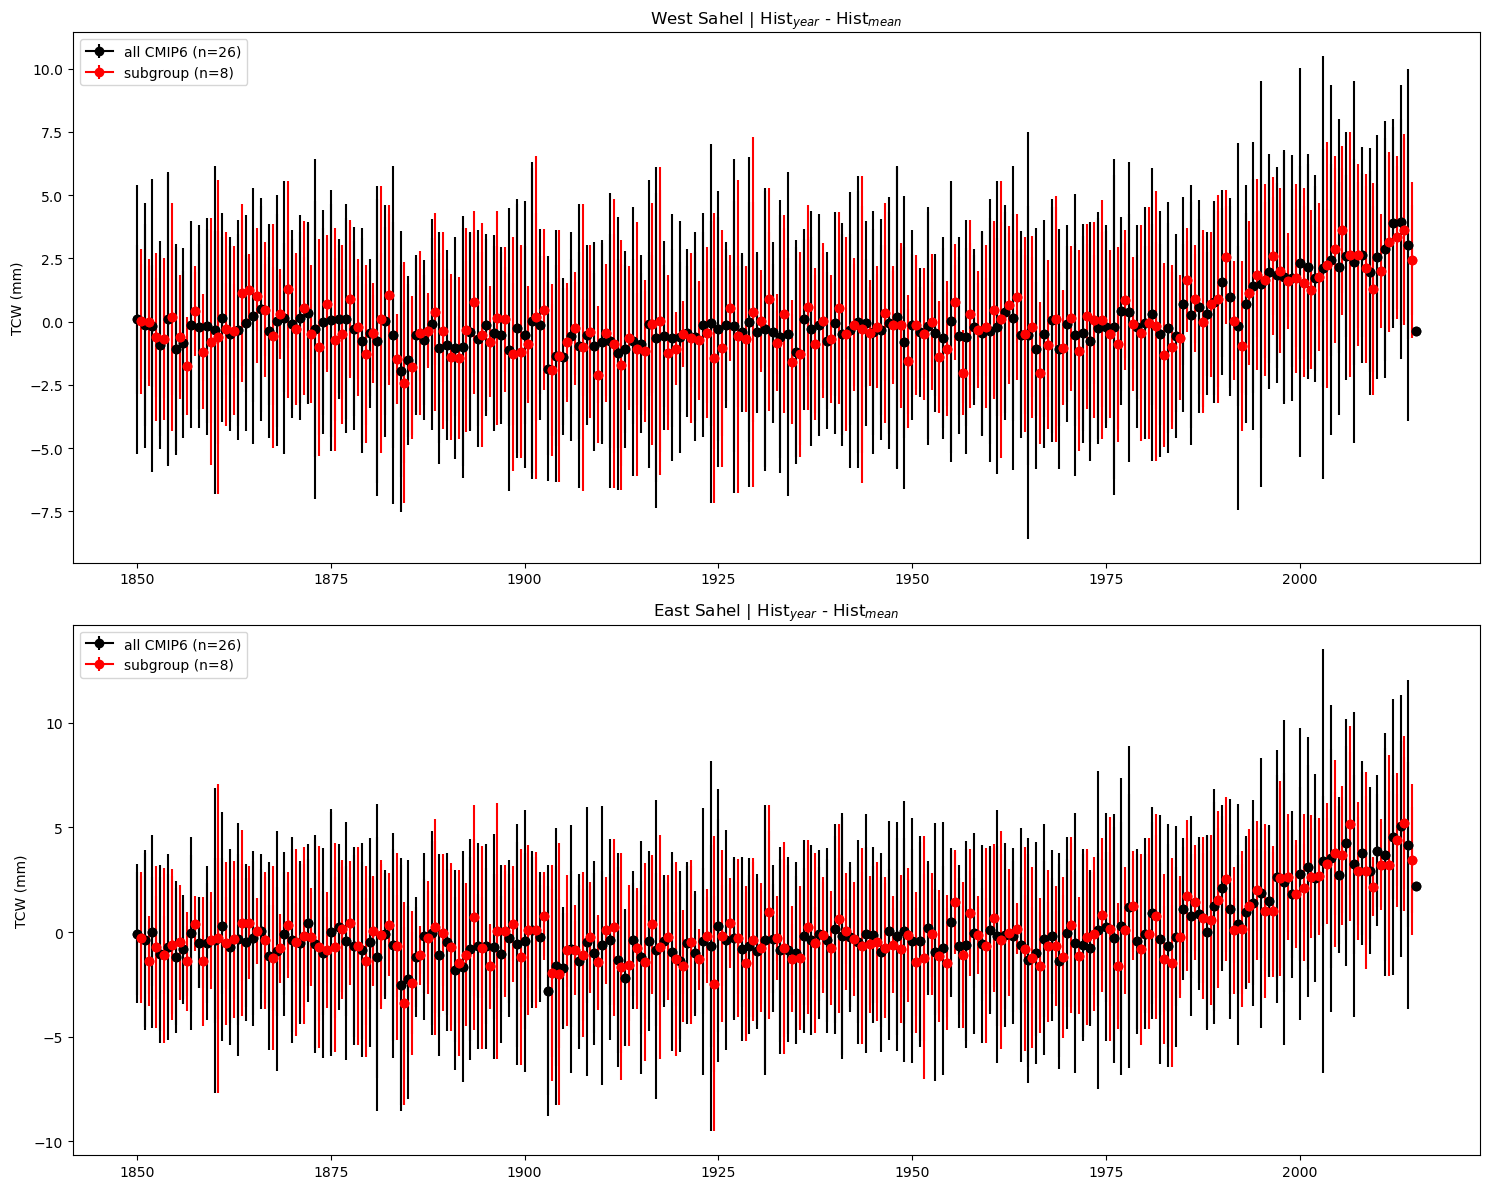

In [82]:
f = plt.figure(figsize=(15,12), dpi=100)
ax = f.add_subplot(211)
dom='wsahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)
for ids, pp in enumerate(wpast.hyear):
    dat = wpast.sel(hyear=pp)
    if ids == 0:
        plt.errorbar([dat.hyear]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o', label='all CMIP6 (n=26)')
    else:
        plt.errorbar([dat.hyear]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o')
        

for ids, pp in enumerate(wgpast.hyear):
    try:
        dat = wgpast.sel(hyear=pp)
    except:
        continue
    if ids == 0:
        plt.errorbar(np.array([dat.hyear]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o', label='subgroup (n=8)')
    else:
        plt.errorbar(np.array([dat.hyear]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o')

        
plt.title('West Sahel | Hist$_{year}$ - Hist$_{mean}$')    
plt.legend(loc='upper left')
plt.ylabel('TCW (mm)')
        
ax = f.add_subplot(212)
dom='sahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)
for ids, pp in enumerate(wpast.hyear):
    dat = wpast.sel(hyear=pp)
    if ids == 0:
        plt.errorbar([dat.hyear]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o', label='all CMIP6 (n=26)')
    else:
        plt.errorbar([dat.hyear]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o')
        

for ids, pp in enumerate(wgpast.hyear):
    try:
        dat = wgpast.sel(hyear=pp)
    except:
        continue
    if ids == 0:
        plt.errorbar(np.array([dat.hyear]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o', label='subgroup (n=8)')
    else:
        plt.errorbar(np.array([dat.hyear]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o')

        
plt.title('East Sahel | Hist$_{year}$ - Hist$_{mean}$')    
plt.legend(loc='upper left')
plt.ylabel('TCW (mm)')
plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/cmip6_TCW_minmax_historical_ssp245.jpg')

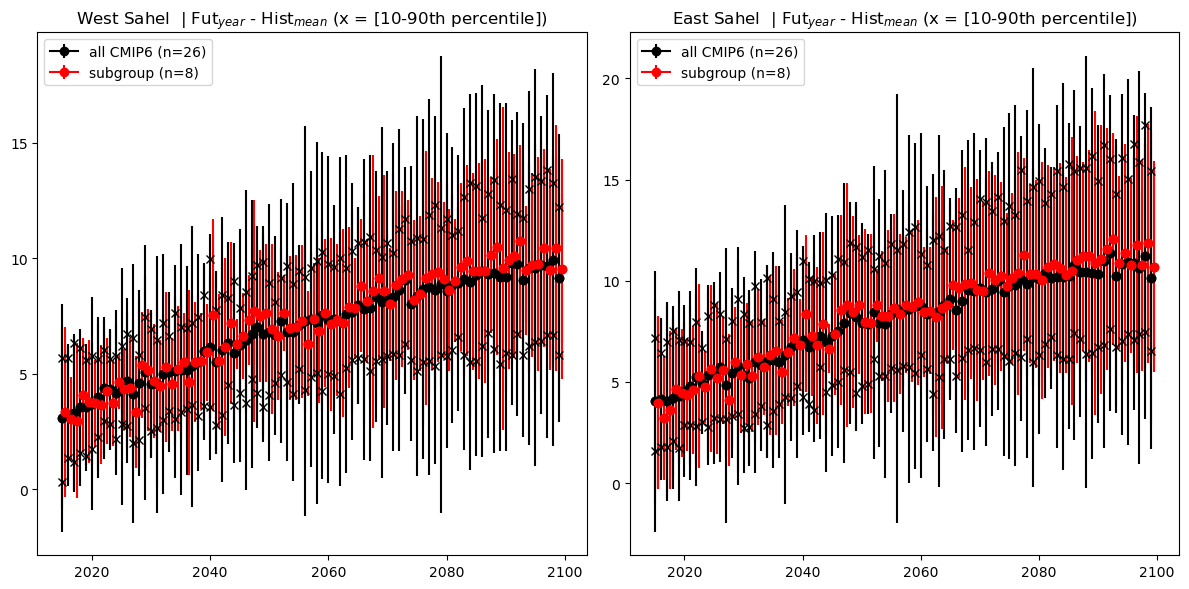

In [134]:
f = plt.figure(figsize=(12,6), dpi=100) # (15,12)
ax = f.add_subplot(121)
dom='wsahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)
for ids, pp in enumerate(wfut.year):
    dat = wfut.sel(year=pp)
    if ids == 0:
        plt.errorbar([dat.year]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o', label='all CMIP6 (n=26)')
    else:
        plt.errorbar([dat.year]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o')
        
    plt.plot(dat.year, np.percentile(dat,90), marker='x', color='k')
    plt.plot(dat.year, np.percentile(dat,10), marker='x', color='k')
        

for ids, pp in enumerate(wgfut.year):
    try:
        dat = wgfut.sel(year=pp)
    except:
        continue
    if ids == 0:
        plt.errorbar(np.array([dat.year]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o', label='subgroup (n=8)')
    else:
        plt.errorbar(np.array([dat.year]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o')

        
plt.title('West Sahel  | Fut$_{year}$ - Hist$_{mean}$ (x = [10-90th percentile])')    
plt.legend(loc='upper left')
        
ax = f.add_subplot(122)
dom='sahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)
for ids, pp in enumerate(wfut.year):
    dat = wfut.sel(year=pp)
    if ids == 0:
        plt.errorbar([dat.year]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o', label='all CMIP6 (n=26)')
    else:
        plt.errorbar([dat.year]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o')
        
        
    plt.plot(dat.year, np.percentile(dat,90), marker='x', color='k')
    plt.plot(dat.year, np.percentile(dat,10), marker='x', color='k')

for ids, pp in enumerate(wgfut.year):
    try:
        dat = wgfut.sel(year=pp)
    except:
        continue
    if ids == 0:
        plt.errorbar(np.array([dat.year]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o', label='subgroup (n=8)')
    else:
        plt.errorbar(np.array([dat.year]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o')

        
plt.title('East Sahel  | Fut$_{year}$ - Hist$_{mean}$ (x = [10-90th percentile])')    
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/cmip6_TCW_minmax_future_ssp245.jpg')

In [137]:
wgfut

<xarray.DataArray 'prw' (model_name: 8, year: 85)>
array([[ 8.202705  ,  0.8308487 ,  5.3312073 ,  7.310482  ,  6.1358223 ,
         6.1380005 ,  4.359787  ,  9.834003  ,  5.874958  ,  9.766792  ,
         8.920448  ,  7.009819  ,  3.8283272 ,  8.702976  ,  4.187008  ,
         6.1615868 ,  5.11467   ,  5.929783  ,  6.6241493 , 10.241837  ,
        10.728195  ,  3.5212708 ,  6.0021553 , 10.562855  ,  9.081814  ,
        11.022591  ,  8.793858  ,  9.991383  , 12.411407  ,  6.737877  ,
        10.354027  , 13.270161  , 14.824997  , 10.345543  , 10.789158  ,
        10.888981  , 12.225502  ,  9.148888  , 11.453484  ,  9.259357  ,
        11.130196  , 12.322319  , 11.311012  , 12.309689  , 10.364616  ,
         9.585194  , 10.6901245 , 14.133514  , 14.694576  , 11.259232  ,
        12.999725  , 14.065876  , 13.909267  ,  8.6387825 , 15.047176  ,
        11.580082  , 13.857975  , 13.684242  , 13.358284  , 12.482613  ,
        13.668358  , 12.306126  , 14.525658  , 10.049263  , 14.7658615 ,
        15.850624  , 15.705898  , 13.051228  , 15.73661   , 10.745735  ,
        17.103352  , 14.413429  , 13.844303  , 13.008064  , 18.38593   ,
        10.179771  , 15.4077835 , 13.136379  , 12.157135  , 15.009048  ,
        12.021511  , 14.652489  , 12.333405  , 17.556679  , 13.271217  ],
       [ 4.4675827 ,  4.5244293 ,  0.95129013,  3.6955032 ,  5.6199303 ,
         2.8091888 ,  6.1434364 ,  5.046921  ,  3.6018639 ,  3.9692993 ,
         5.2117424 ,  4.3196564 ,  3.5992203 ,  6.927559  ,  5.711117  ,
...
         7.852894  , 10.662308  , 11.485531  ,  8.398563  , 10.391232  ,
        11.524414  ,  9.437187  ,  9.079948  ,  9.0415535 ,  7.459484  ],
       [ 1.9792938 ,  6.2921906 ,  4.3945847 ,  2.062481  ,  5.6420555 ,
         5.31728   ,  6.122799  ,  4.6214905 ,  6.5202255 ,  5.8678207 ,
         6.033531  ,  8.25452   ,  4.496414  ,  6.201889  ,  4.039963  ,
         7.337696  ,  6.0429077 ,  8.33873   ,  6.115261  ,  8.834915  ,
         5.9521637 ,  8.083599  ,  7.7336082 ,  9.476353  ,  7.7209167 ,
         9.756886  ,  9.885021  ,  9.960171  ,  9.103367  ,  5.859329  ,
         9.098587  , 11.025711  , 10.567104  , 13.183529  , 11.053524  ,
        11.3640175 , 12.323971  , 10.536125  ,  8.721672  , 12.491264  ,
        10.623936  ,  9.942684  , 12.181019  , 10.661739  , 13.007004  ,
        10.714428  , 10.632126  , 10.647785  , 12.193417  ,  9.030243  ,
        12.771633  , 12.318344  , 12.216549  , 10.229912  , 11.033325  ,
        13.355602  , 13.898064  , 11.4691925 , 12.268822  , 13.296452  ,
        14.268032  , 11.19556   , 12.228844  , 14.76408   , 13.473217  ,
        13.52388   , 12.912838  , 13.723724  , 15.837971  , 12.34425   ,
        11.295422  , 15.277031  , 15.107563  , 16.45811   , 16.80011   ,
        13.840046  , 14.592831  , 17.246456  , 12.990322  , 16.121323  ,
        14.926636  , 15.873302  , 15.985882  , 17.756794  , 15.878208  ]],
      dtype=float32)
Coordinates:
    hyear       int64 1851
  * model_name  (model_name) object 'ACCESS-CM2' 'CESM2-WACCM' ... 'UKESM1-0-LL'
  * year        (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099

ACCESS-CM2 928.22906
AWI-CM-1-1-MR 787.7184
BCC-CSM2-MR 543.53577
CAMS-CSM1-0 428.07718
CESM2-WACCM 652.5998
CIESM 377.67758
CNRM-CM6-1 645.38464
CNRM-CM6-1-HR 651.1147
CNRM-ESM2-1 652.3422
CanESM5 1211.1156
EC-Earth3-Veg 1047.3569
FGOALS-g3 537.0957
GFDL-CM4 608.0375
GFDL-ESM4 462.778
HadGEM3-GC31-LL 836.1004
INM-CM4-8 486.34308
IPSL-CM6A-LR 950.68964
KACE-1-0-G 772.67017
MIROC-ES2L 567.6303
MIROC6 491.9392
MPI-ESM1-2-HR 622.2654
MRI-ESM2-0 707.59937
NorESM2-LM 678.0123
NorESM2-MM 643.55
UKESM1-0-LL 905.3277


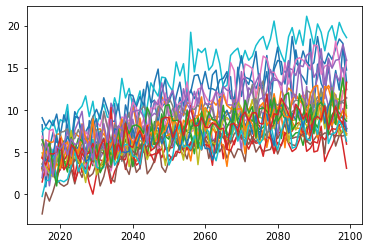

In [116]:
for pp in wfut:
    plt.plot(pp.year, pp)
    print(pp.model_name.values, np.sum(pp.values))

ACCESS-CM2 928.22906
CESM2-WACCM 652.5998
CNRM-CM6-1 645.38464
INM-CM4-8 485.37927
IPSL-CM6A-LR 950.68964
MIROC6 491.9392
MPI-ESM1-2-HR 622.2654
UKESM1-0-LL 905.3277


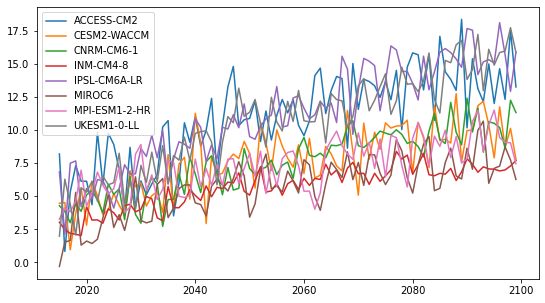

In [135]:
f = plt.figure(figsize=(9,5))
for pp in wgfut:
    #if pp.model_name.values in ['ACCESS-CM2', 'IPSL-CM6A-LR', 'UKESM1-0-LL']:
    #    continue
    plt.plot(pp.year, pp, label=pp.model_name.values)
    print(pp.model_name.values, np.sum(pp.values))
    plt.legend()
plt.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/cmip6_TCW_sgroup_ssp245.jpg')